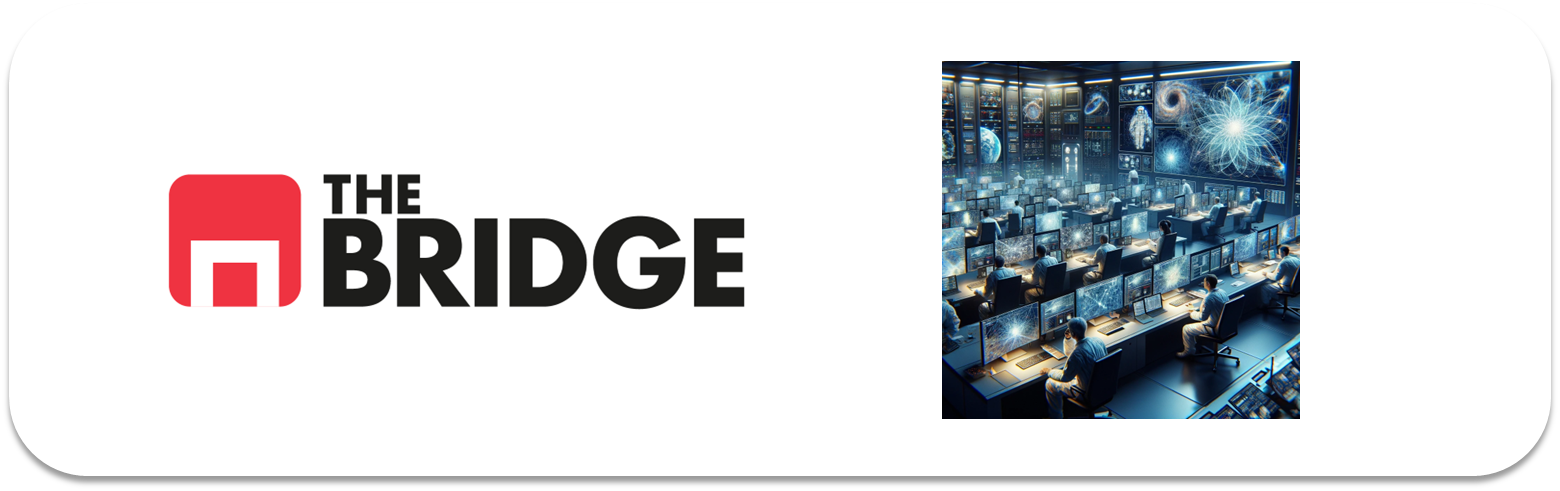

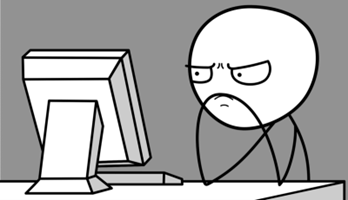

Para ejercitarte y afianzar lo aprendido sobre **Redes Convolucionales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import cv2

## El problema de "Negocio"
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test como `seg_train.zip` y `seg_test.zip` (o bien en el botón de download).  

NOTA: Son archivos bastante grandes (386MB en total). Por supuesto, no es necesario que tengas que mantenerlos en tu ordenador una vez realizado el ejercicio, bórralos si es el caso.




### Ejercicio 1

Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones). Para ello:

1. Descarga las imagenes del repositorio de Kaggle en el directorio que vayas a emplear para el ejercicio.
2. Descomprime los datos (son ficheros de imágenes) de forma que tengas dos subdirectorios seg_train y seg_test en el que estén ya colgando directamente los directorios de cada clase de paisajes. Si descargaste seg_pred, puedes eliminarlo.
3. Crea unas variables como las siguientes (ajustándolas a tu caso/rutas particulares):

```python
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"
```
4. Utiliza la siguiente función para crear los X_train, y_train y X_test e y_test:

```python
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)
```


*Pues copiamos lo que nos dicen y lo aplicamos a los dos directorios para tener las X y las y*

In [21]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"



In [22]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

### Ejercicio 2

Haz la visualización del dataset: comprueba cuantos datos tienes, que forma, investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.


In [23]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH) # Nota: podríamos dejar la creación de X_test para el final antes de usarlo y así ahorra memoria mientras no tengamos que emplearlo

buildings


forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [24]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 32, 32, 3)
Y train shape:  (14034,)


In [25]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (3000, 32, 32, 3)
Y train shape:  (3000,)


In [26]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

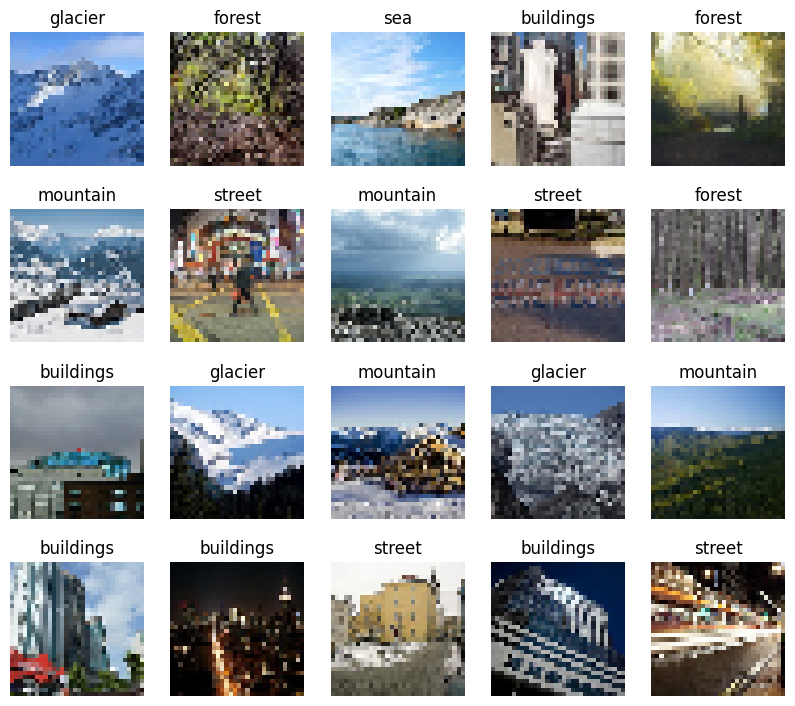

In [27]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

### Ejercicio 3

Ahora haz un pequeño miniEda y normaliza las features



In [28]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [29]:
X_train = X_train/255
X_test = X_test/255

### Ejercicio 4

Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada. Como guía, copia o parte de la arquitectura del workout (un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer)


In [30]:
# Primero definimos las capas de la red, en este caso partimos de 30 filtros de 3x3, seguido de una capa de pooling de 2x2,
# El input shape es el tamaño de las imágenes de entrada, en nuestro caso 32x32x3. 
# El tamaño del kernel es pequeño pero suele ser de este tipo y más con resoluciones tan bajas, el número de filtros está escogido de aquella manera,
# juega con el número de filtros.

capas = [keras.layers.Conv2D(filters = 30, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 15, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 150, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(6, activation = 'softmax')]

# Creamos el modelo
model = keras.Sequential(capas)

### Ejercicio 5

Escoge el resto de hiperparámetros (optimizador, learning_rate, función de pérdida, métrica,...) y compila el modelo. Muestra un resumen del mismo

In [31]:
X_train.size

43112448

In [32]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 30)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 15)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 150)               1

### Ejercicio 6

Entrena el modelo reservando un 20% de los datos del entrenamiento para validar y con los callbacks que creas necesarios. NOTA: Ojo, tendrás que preparar un poco los X,y antes.



In [34]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [35]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [36]:
# Revolvemos los datos para que el modelo no aprenda en orden de las imágenes
X_train, y_train_num = shuffle(X_train, y_train_num)

In [37]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)]) # Queremos recuperar los pesos de la mejor de las epocas durante el periodo de patience

Epoch 1/100


351/351 [==============================] - 2s 4ms/step - loss: 1.0958 - accuracy: 0.5670 - val_loss: 0.9210 - val_accuracy: 0.6562
Epoch 2/100
351/351 [==============================] - 1s 4ms/step - loss: 0.8553 - accuracy: 0.6738 - val_loss: 0.8254 - val_accuracy: 0.6929
Epoch 3/100
351/351 [==============================] - 1s 4ms/step - loss: 0.7377 - accuracy: 0.7249 - val_loss: 0.8256 - val_accuracy: 0.7025
Epoch 4/100
351/351 [==============================] - 1s 4ms/step - loss: 0.6717 - accuracy: 0.7532 - val_loss: 0.8011 - val_accuracy: 0.7057
Epoch 5/100
351/351 [==============================] - 1s 4ms/step - loss: 0.5985 - accuracy: 0.7805 - val_loss: 0.6865 - val_accuracy: 0.7510
Epoch 6/100
351/351 [==============================] - 1s 4ms/step - loss: 0.5450 - accuracy: 0.7993 - val_loss: 0.6922 - val_accuracy: 0.7367
Epoch 7/100
351/351 [==============================] - 1s 4ms/step - loss: 0.4901 - accuracy: 0.8187 - val_loss: 0.7199 - val_accuracy: 0.75


### Ejercicio 7

Representa el objeto history y comenta la evolución de tu entrenamiento.



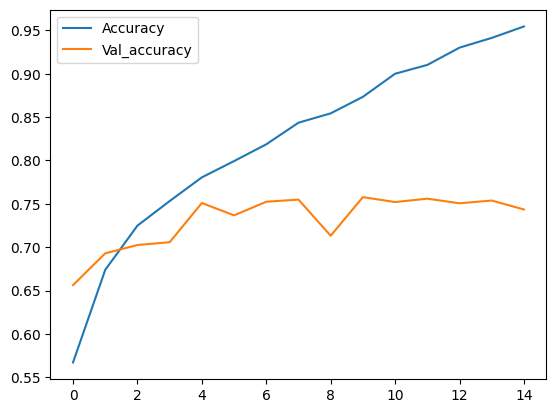

In [38]:
# Representamos el objeto history
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

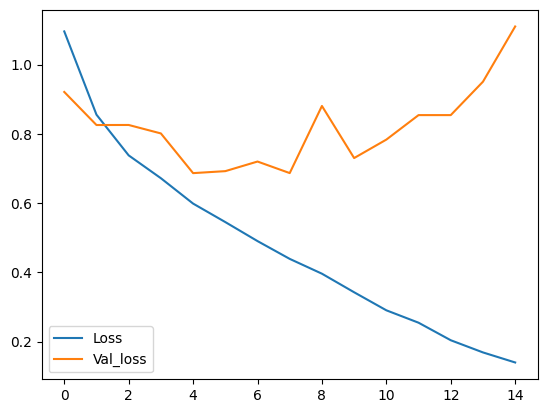

In [39]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();


### Ejercicio 8

Evalua el modelo con los datos de test, además muestra el report de clasificación y la matriz de confusión.



In [40]:
model.evaluate(X_test, y_test_num)

94/94 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.7573


[0.6797692775726318, 0.7573333382606506]

In [41]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 [==============================] - 0s 1ms/step


In [42]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.69      0.71      0.70       437
      forest       0.90      0.91      0.91       474
     glacier       0.77      0.68      0.72       553
    mountain       0.70      0.76      0.73       525
         sea       0.69      0.75      0.72       510
      street       0.83      0.74      0.78       501

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000



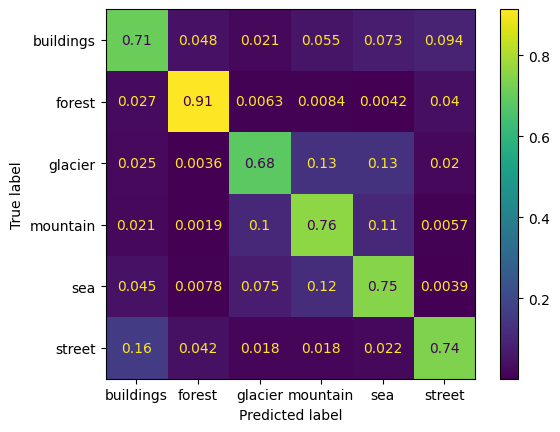

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")


### Ejercicio 9 

Representa algunos de los paisajes donde el modelo comete errores y muestra la confianza que tenía en ellos.





In [44]:
confianza = [prediction.max() for prediction in model.predict(X_test)]

94/94 [==============================] - 0s 1ms/step


In [45]:
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

In [46]:
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores

,True,Predicted,Confianza
2673,street,forest,0.994005
1904,mountain,sea,0.993423
373,buildings,sea,0.990560
1260,glacier,sea,0.989939
79,buildings,forest,0.988821
...,...,...,...
81,buildings,street,0.274196
2208,sea,forest,0.271681
1751,mountain,buildings,0.270274
771,forest,glacier,0.253344


In [47]:
for true_label, predicted_label in errores.iloc[0:10,0:2].values:
    print(true_label, predicted_label)

street forest
mountain sea
buildings sea
glacier sea
buildings forest
buildings sea
glacier sea
street mountain
mountain sea
buildings forest


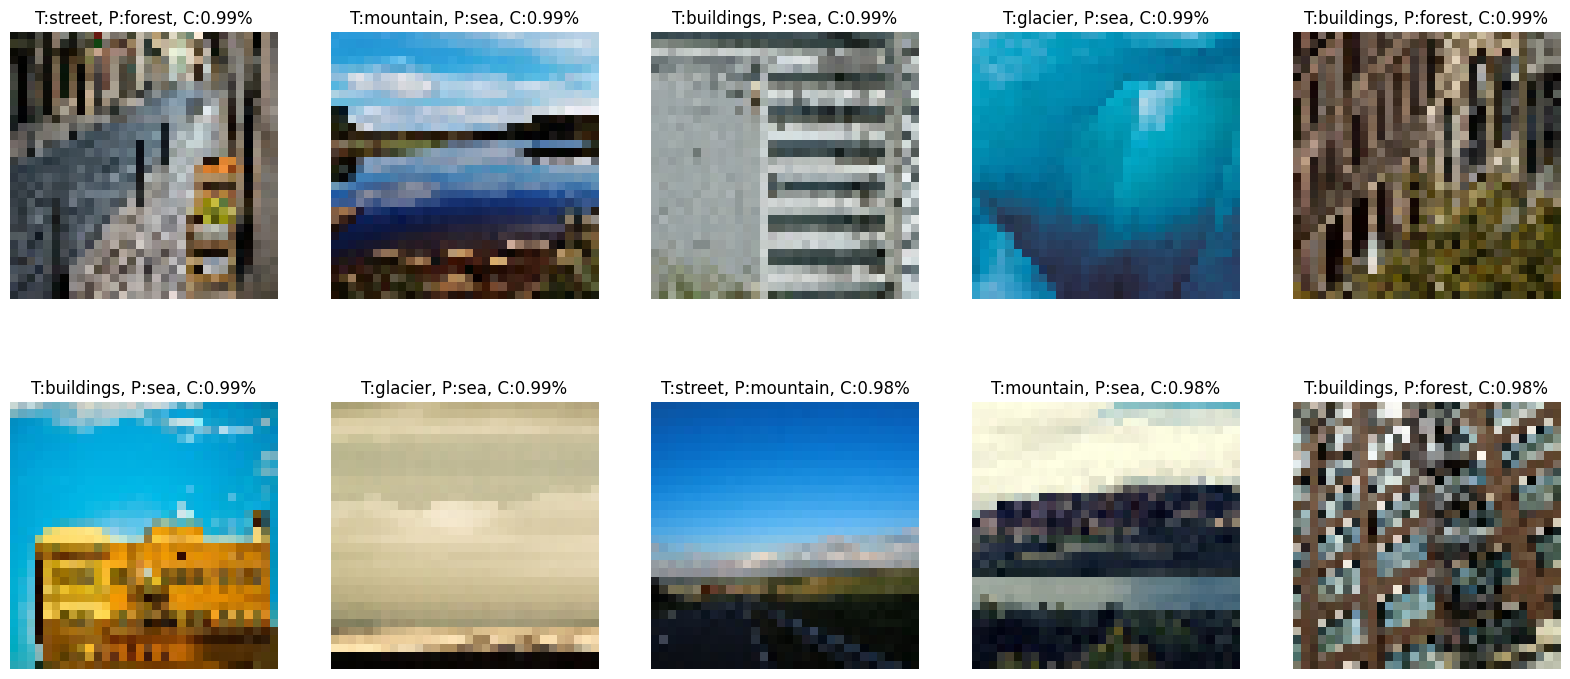

In [48]:
show_images_batch(X_test[errores.iloc[0:10].index],names= [f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in errores.iloc[0:10].values], size_scale= 4)

### Ejercicio EXTRA: 

Aumenta la resolución y repite el ejercicio con la misma topología de red

In [49]:
X_train,y_train = read_data(TRAIN_PATH, (64,64))
X_test, y_test = read_data(TEST_PATH, (64,64))

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


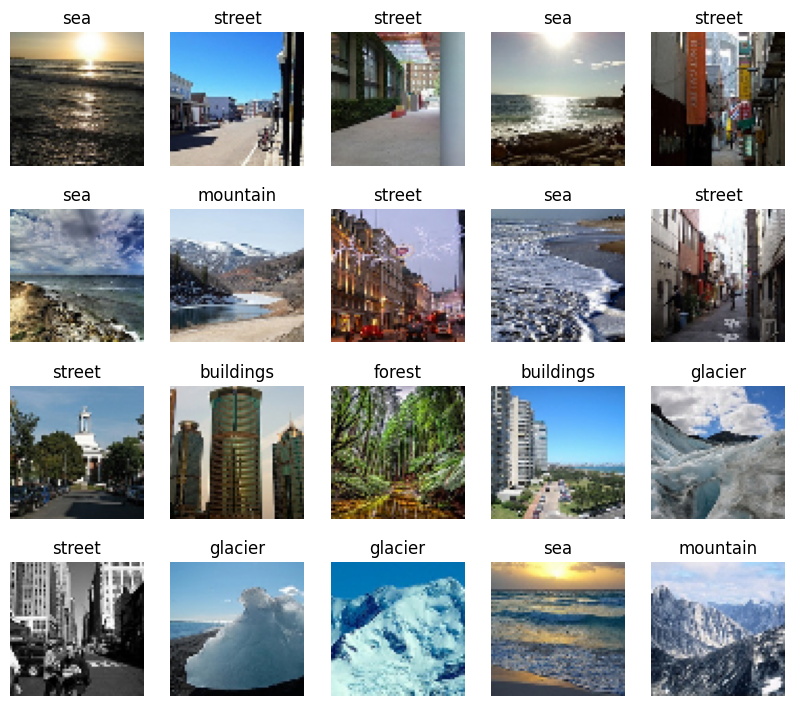

In [50]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [51]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [52]:
X_train, y_train_num = shuffle(X_train, y_train_num)

In [53]:

capas = [keras.layers.Conv2D(filters = 32, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 16, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 300, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(6, activation = 'softmax')]

# Creamos el modelo
model = keras.Sequential(capas)

In [54]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 300)              

In [56]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 64, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)])

Epoch 1/100
176/176 [==============================] - 6s 30ms/step - loss: 2.6471 - accuracy: 0.4891 - val_loss: 0.9795 - val_accuracy: 0.6138
Epoch 2/100
176/176 [==============================] - 5s 30ms/step - loss: 0.8678 - accuracy: 0.6733 - val_loss: 0.9112 - val_accuracy: 0.6473
Epoch 3/100
176/176 [==============================] - 6s 32ms/step - loss: 0.6533 - accuracy: 0.7600 - val_loss: 0.8971 - val_accuracy: 0.6641
Epoch 4/100
176/176 [==============================] - 6s 33ms/step - loss: 0.4512 - accuracy: 0.8356 - val_loss: 1.0204 - val_accuracy: 0.6587
Epoch 5/100
176/176 [==============================] - 6s 33ms/step - loss: 0.3144 - accuracy: 0.8886 - val_loss: 1.1491 - val_accuracy: 0.6737
Epoch 6/100
176/176 [==============================] - 5s 31ms/step - loss: 0.2492 - accuracy: 0.9131 - val_loss: 1.1477 - val_accuracy: 0.6897
Epoch 7/100
176/176 [==============================] - 5s 31ms/step - loss: 0.1532 - accuracy: 0.9479 - val_loss: 1.3126 - val_accuracy:

In [57]:
model.evaluate(X_test, y_test_num)

94/94 [==============================] - 0s 4ms/step - loss: 0.9194 - accuracy: 0.6533


[0.919360339641571, 0.653333306312561]

In [58]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 [==============================] - 0s 4ms/step


In [59]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.51      0.68      0.58       437
      forest       0.81      0.87      0.84       474
     glacier       0.70      0.62      0.66       553
    mountain       0.61      0.57      0.59       525
         sea       0.60      0.56      0.58       510
      street       0.72      0.64      0.68       501

    accuracy                           0.65      3000
   macro avg       0.66      0.66      0.65      3000
weighted avg       0.66      0.65      0.65      3000



In [60]:
confianza = [prediction.max() for prediction in model.predict(X_test)]
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

94/94 [==============================] - 0s 3ms/step


In [61]:
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores

,True,Predicted,Confianza
79,buildings,forest,0.999999
407,buildings,forest,0.999363
86,buildings,street,0.998839
381,buildings,forest,0.998209
2095,sea,glacier,0.998114
...,...,...,...
2213,sea,buildings,0.255951
1068,glacier,street,0.244216
1282,glacier,sea,0.241993
1680,mountain,glacier,0.239913


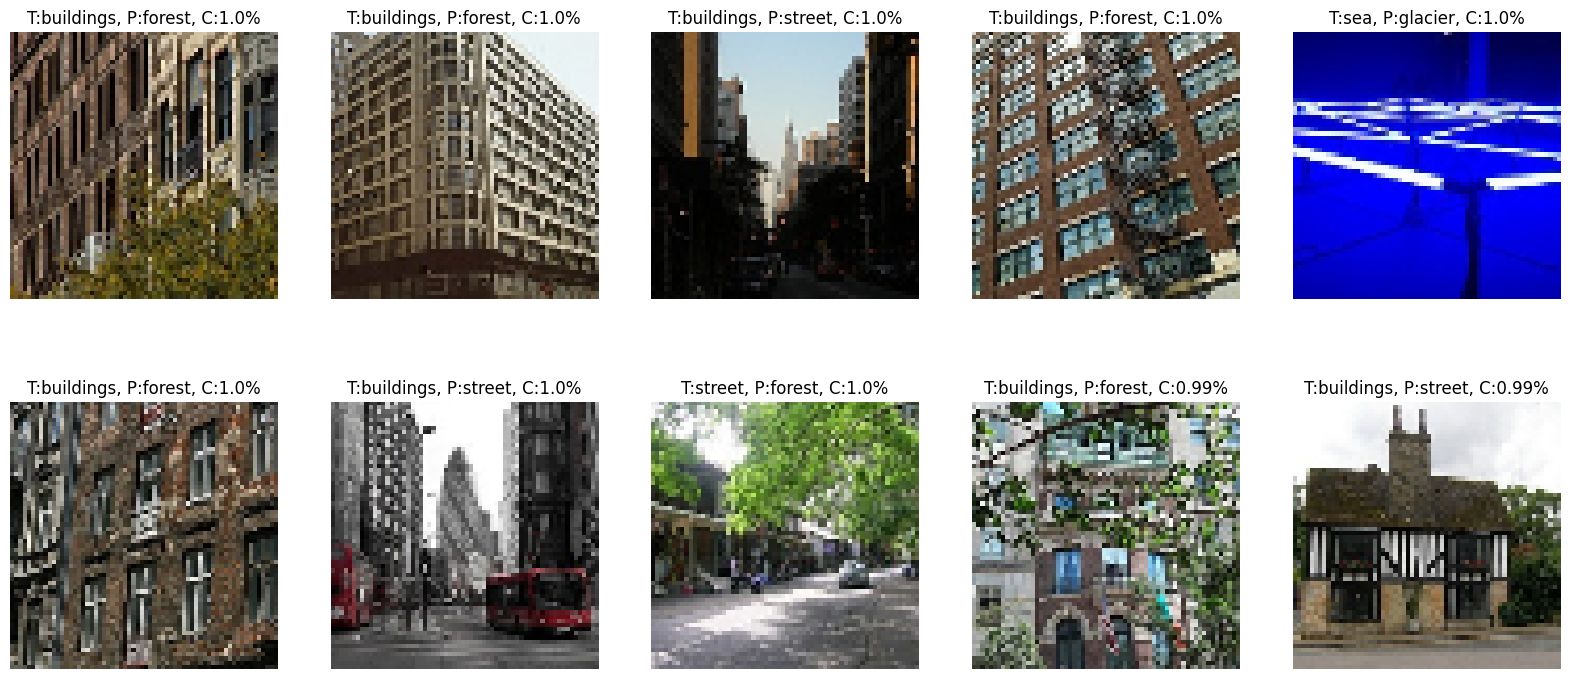

In [62]:
show_images_batch(X_test[errores.iloc[0:10].index],names= [f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in errores.iloc[0:10].values], size_scale= 4)